# Ex 11

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from util_functions import triangulate

In [45]:
cv2.__version__

'4.6.0'

In [46]:
folder = 'media/Glyp/'
K = np.loadtxt(folder+'K.txt')
K

array([[3.1174740e+03, 0.0000000e+00, 1.5019408e+03],
       [0.0000000e+00, 3.1174740e+03, 9.8476840e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

In [47]:
im0 = cv2.imread(folder+"sequence/000001.png")
im1 = cv2.imread(folder+"sequence/000002.png")
im2 = cv2.imread(folder+"sequence/000003.png")

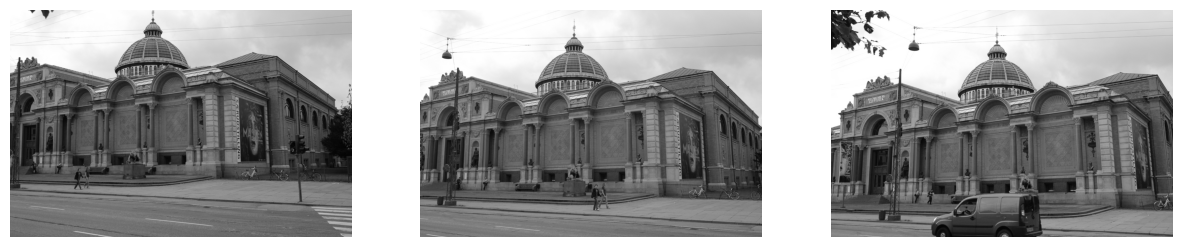

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(im0)
ax[0].axis('off')
ax[1].imshow(im1)
ax[1].axis('off')
ax[2].imshow(im2)
ax[2].axis('off')
plt.show()

In [49]:
# Ex 11.1
# Find and match SIFT keypoints

n_features = 2000   # limit for speed reasons
sift = cv2.SIFT_create(nfeatures=2000)
kp0, des0 = sift.detectAndCompute(im0, None)
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

# Convert to np arrays of 2D points
kp0 = np.array([k.pt for k in kp0])
kp1 = np.array([k.pt for k in kp1])
kp2 = np.array([k.pt for k in kp2])

bf = cv2.BFMatcher_create(crossCheck=True)
matches01 = bf.match(des0, des1)
matches12 = bf.match(des1, des2)

# Convert to np arrays of the indices
matches01 = np.array([(m.queryIdx, m.trainIdx) for m in matches01])
matches12 = np.array([(m.queryIdx, m.trainIdx) for m in matches12])

In [50]:
matches01   
# contains the indices of the matched keypoints in im0 and im1

array([[   0, 1593],
       [   4,  209],
       [   5,  365],
       ...,
       [1986, 1808],
       [1989, 1431],
       [1995,  103]])

In [51]:
print(matches01.shape)  # correct shape, checked with TA
print(matches12.shape)

(958, 2)
(860, 2)


In [52]:
# Ex 11.2
# Estimate essential matrix, decompose, find pose, keep inliers only


E01_find, mask01_find = cv2.findEssentialMat(
    kp0[matches01[:, 0]],
    kp1[matches01[:, 1]],
    K,
)
E12_find, mask12_find = cv2.findEssentialMat(
    kp1[matches12[:, 0]],
    kp2[matches12[:, 1]],
    K,
)
# masks: indicates which matches are inliers

# Decompose E to get R, t
E01_rec, R01, t01, mask01_rec = cv2.recoverPose(
    E01_find, kp0[matches01[:, 0]], kp1[matches01[:, 1]], K
)
E12_rec, R12, t12, mask12_rec = cv2.recoverPose(
    E12_find, kp1[matches12[:, 0]], kp2[matches12[:, 1]], K
)
# masks: indicates which matches lie in front of cameras

# FIX: somehow, mask_rec returns array of [0] and [255]
mask01_rec = (mask01_rec / 255).astype(int)
mask12_rec = (mask12_rec / 255).astype(int)

# Combine masks: matches that are inliers and lie in front of cameras
combined_mask01 = np.logical_and(mask01_find, mask01_rec)
combined_mask12 = np.logical_and(mask12_find, mask12_rec)

# Only keep matches that are inliers
new_matches01 = matches01[combined_mask01.ravel()]
new_matches12 = matches12[combined_mask12.ravel()]

In [53]:
print(f"No. of inliers: {mask01_find.sum()}")   # inliers have the value of 1

No. of inliers: 675


In [54]:
print(R01)
print(t01)

[[ 0.99986031 -0.00870514 -0.0142681 ]
 [ 0.00937649  0.99881855  0.04768206]
 [ 0.01383616 -0.04780919  0.99876065]]
[[ 0.92508972]
 [-0.06815487]
 [-0.37358255]]


In [55]:
print(f"mask01_find: {mask01_find.shape}")
print(f"mask01_rec: {mask01_rec.shape}")
print(f"combined_mask01: {combined_mask01.shape}")
print(f"new_matches01: {new_matches01.shape}\n")

print(f"mask12_find: {mask12_find.shape}")
print(f"mask12_rec: {mask12_rec.shape}")
print(f"combined_mask12: {combined_mask12.shape}")
print(f"new_matches12: {new_matches12.shape}")


mask01_find: (958, 1)
mask01_rec: (958, 1)
combined_mask01: (958, 1)
new_matches01: (673, 2)

mask12_find: (860, 1)
mask12_rec: (860, 1)
combined_mask12: (860, 1)
new_matches12: (549, 2)


In [56]:
print(f"new_matches01:\n {new_matches01}")
print(f"new_matches12:\n {new_matches12}")

print(f"E01_find:\n{E01_find/E01_find[2,2]}")
print(f"E12_find:\n{E12_find/E12_find[2,2]}")

new_matches01:
 [[  13  203]
 [  14  402]
 [  20  180]
 ...
 [1973 1871]
 [1981 1889]
 [1982 1955]]
new_matches12:
 [[   2  204]
 [   3 1590]
 [   7 1238]
 ...
 [1942 1720]
 [1949 1473]
 [1967 1225]]
E01_find:
[[  0.0593423    8.72552833  -1.1650404 ]
 [ -8.95573144   1.10065729 -21.29487558]
 [  1.78079423  21.4059286    1.        ]]
E12_find:
[[ -0.17063896  22.38419258  -4.37348621]
 [-22.50878332   0.90649858 -32.54469671]
 [  4.89509264  32.75882739   1.        ]]


In [58]:
# Ex 11.3
# Find subset of matches that are present from image0->image2
_, idx01, idx12 = np.intersect1d(new_matches01[:,1], matches12[:,0], return_indices=True)
# idx01 (np.array): contains indices of intersection in matches01
# idx12 (np.array): contains indices of intersection in matches12

# Lists contain 2D locations of the same point across images
points0 = kp0[new_matches01[idx01,0]]
points1 = kp1[new_matches01[idx01,1]]
points2 = kp2[matches12[idx12,1]]

print(points0.shape, points1.shape, points2.shape)  # should be equal

(355, 2) (355, 2) (355, 2)


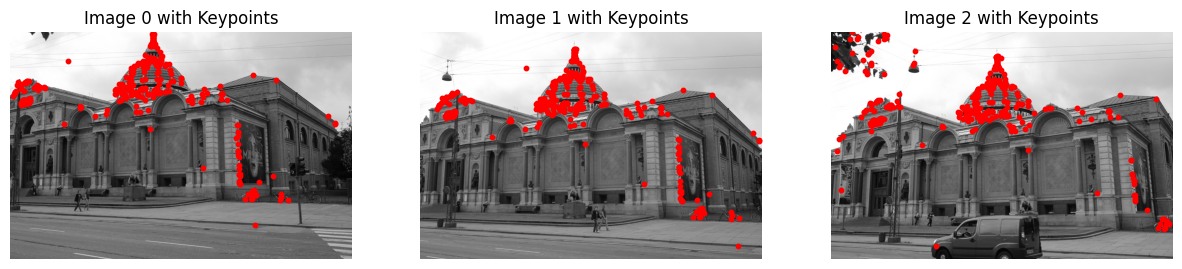

In [59]:
# Plot the matches

# Plot the keypoints on images 0, 1, and 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot image 0 with keypoints
axes[0].imshow(cv2.cvtColor(im0, cv2.COLOR_BGR2RGB))
axes[0].scatter(points0[:, 0], points0[:, 1], c='r', s=10)
axes[0].set_title('Image 0 with Keypoints')
axes[0].axis('off')

# Plot image 1 with keypoints
axes[1].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
axes[1].scatter(points1[:, 0], points1[:, 1], c='r', s=10)
axes[1].set_title('Image 1 with Keypoints')
axes[1].axis('off')

# Plot image 2 with keypoints
axes[2].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
axes[2].scatter(points2[:, 0], points2[:, 1], c='r', s=10)
axes[2].set_title('Image 2 with Keypoints')
axes[2].axis('off')

plt.show()

In [60]:
# Ex 11.4
# use the 2D positions in image 0 and 1 to triangulate the points in 3D (Q)

# Set camera 1 as the origin
P1 = np.hstack((np.eye(3), np.zeros((3,1))))
P2 = np.hstack((R01, t01))
P_list = [P1, P2]

Q = np.zeros((len(points0), 3, 1)) # store triangulated 3D points

for i in range(len(points0)):
    q_list = [points0[i,:], points1[i,:]]
    Qi = triangulate(q_list, P_list)
    Q[i,:] = Qi

print(Q.shape)
Q = Q.reshape(-1, 3)
print(Q.shape)


(355, 3, 1)
(355, 3)


In [63]:
# Using cv2.triangulatePoints

Q4d = cv2.triangulatePoints(P1, P2, points0.T, points1.T)
Q3d = Q4d[:3] / Q4d[3]

distCoeffs = np.zeros(5)
retval, rvec, tvec, inliers = cv2.solvePnPRansac(Q3d.T, points2, K, distCoeffs)

print("Rotation Vector:")
print(rvec)
print("Translation Vector:")
print(tvec)
print("Inliers:")
print(inliers)


Rotation Vector:
[[ 1.2148709 ]
 [-1.29385908]
 [ 0.65303952]]
Translation Vector:
[[-3.39391292]
 [ 2.03999694]
 [-7.75319868]]
Inliers:
[[  1]
 [ 23]
 [157]
 [292]
 [309]
 [340]]


In [62]:
distCoeffs = np.zeros(5)

# Estimate the pose using solvePnPRansac
## Q: 3D coordinates of the corresponding points in the real world
## points1: 2D coordinates of the corresponding points in the image
retval, rvec, tvec, inliers = cv2.solvePnPRansac(Q, points2, K, distCoeffs)

print("Rotation Vector:")
print(rvec)
print("Translation Vector:")
print(tvec)

Rotation Vector:
[[ 1.2148709 ]
 [-1.29385908]
 [ 0.65303952]]
Translation Vector:
[[-3.39391292]
 [ 2.03999694]
 [-7.75319868]]


In [ ]:
inliers.flatten()

AttributeError: 'NoneType' object has no attribute 'flatten'

In [64]:
# Visualize 3D points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*Q[inliers.flatten()])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Error in callback <function _draw_all_if_interactive at 0x000001A9BA5B40E0> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'Path3DCollection' object has no attribute '_offsets3d'

AttributeError: 'Path3DCollection' object has no attribute '_offsets3d'

<Figure size 640x480 with 1 Axes>